In [ ]:
! pip install transformers
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import transformers
from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup
import tqdm.auto as tqdm
import torch.nn.functional as F
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score,f1_score,roc_curve
from torch import nn,optim
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 4
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')
!wget https://www.easynepalityping.com/resource/font/bangla/06-nikosh-bangla-font.zip
!unzip 06-nikosh-bangla-font.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/my_thesis/data.csv")
df.sample(10)

,post,aspect,polarity
6365,মুসলিমের আলোর পথে আনার জন্য তিনি হলেন এক মাত্র...,religion,positive
2484,এই গোমূত্র সেবিরা আবার যুদ্ধ করবে !!!,other,negative
2508,"বিশ্বকাপ পাক না পাক, ভালোবাসা সব সময় থাকবে",sports,positive
6100,আল্লাহ্ তাকে শান্তিতে রাখুন।,religion,positive
1188,"বিসিবি থেকে,নান্নু আর পাপনকে আগে বাদ দিতে হবে।।",sports,negative
7620,সন্ত্রাসবাদ ও জিহাদ এই লেকচারটা মনে হয় আগেও শু...,religion,positive
315,উগান্ডারর সংবিধানের দোহায় বাংলাদেশে দিয়েন না!!,politics,negative
1568,যারা মুক্তি যোদ্ধাকে সম্মান দিতে জানেনা তাদের ...,other,negative
6336,আওয়ামী লীগের রাজনীতি সম্পূর্ণরূপে মিথ্যা,politics,negative
8886,নবম শ্রেণীতে থাকাবস্তায় ধর্ষকের খাতায় নাম লিখি...,other,negative


In [4]:
#check the rows and columns number.
print(f"number of rows:--> {df.shape[0]} and number of columns:--> {df.shape[1]}")

number of rows:--> 9015 and number of columns:--> 3


In [5]:
#check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9015 entries, 0 to 9014
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   post      9015 non-null   object
 1   aspect    9015 non-null   object
 2   polarity  9014 non-null   object
dtypes: object(3)
memory usage: 211.4+ KB


In [6]:
#check for missing values 
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
polarity,1,0.000111
post,0,0.000000
aspect,0,0.000000


In [7]:
df=df.dropna()

In [8]:
#check for missing values 
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
post,0,0.0
aspect,0,0.0
polarity,0,0.0


In [9]:
#check for dublicated rows
print("Numbers of duplicated rows :",df.duplicated().sum())

Numbers of duplicated rows : 7


In [10]:
#dropping the duplicated rows 
df=df.drop_duplicates(keep="first")
print("After removing,now number of duplicated rows are:",df.duplicated().sum())

After removing,now number of duplicated rows are: 0


# EDA and Preprocessing

In [11]:
df.aspect.value_counts()

other       3009
politics    2663
religion    1752
sports      1583
Name: aspect, dtype: int64

Text(0.5, 0, 'category')

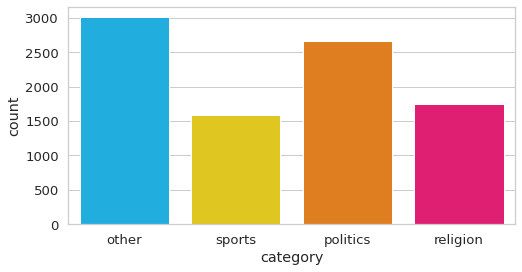

In [12]:
#check for imblanced classes
sns.countplot(data=df,x="aspect")
plt.xlabel('category') 

In [13]:
df.polarity.value_counts()

negative    4722
positive    2616
neutral     1669
Name: polarity, dtype: int64

Text(0.5, 0, 'category')

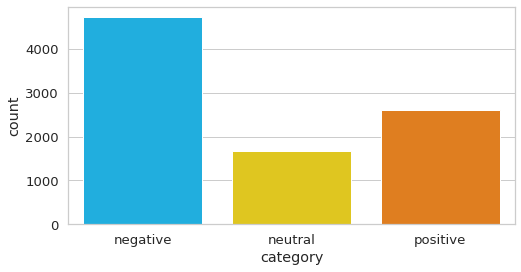

In [14]:
#check for imblanced classes
#check for imblanced classes
sns.countplot(data=df,x="polarity")
plt.xlabel('category') 

In [15]:
#counting text length
df['count'] = df['post'].str.split().str.len()

# Remove the text with words less than 3
df= df.loc[df['count']>3]


In [16]:
df.head()

,post,aspect,polarity,count
0,ছি. এর চেয়ে নিরখিষণ্ট আর কিছু হতে পারেনা।,other,negative,8
1,এটা ফুটবল ইতিহাসের দুভাগ্য,sports,negative,4
2,এই হল সংলাপের নমুনা ।,other,neutral,5
3,আওয়ামীলীগের নোংরা রাজনীতির তীব্র নিন্দা জানাই।,politics,negative,6
4,আমার পরিসংখ্যান অনুযায়ী বলা যাচ্ছে এটা ম্যাশের...,sports,neutral,11


In [17]:
df.shape

(7860, 4)

Text(0.5, 0, 'category')

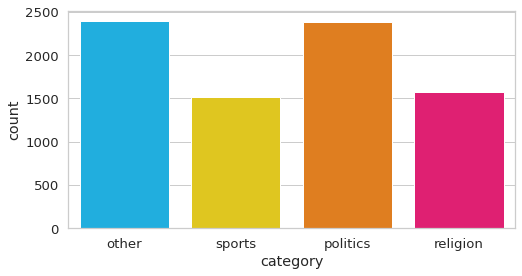

In [18]:
#check for imblanced classes
#check for imblanced classes
sns.countplot(data=df,x="aspect")
plt.xlabel('category')  

In [19]:
df.aspect.value_counts()

other       2390
politics    2384
religion    1575
sports      1511
Name: aspect, dtype: int64

In [20]:
import re
def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [21]:
df['cleanText'] = df.post.apply(lambda x: preprocessing(str(x)))

In [22]:
df.sample(10)

,post,aspect,polarity,count,cleanText
2634,উন্নয়নের ধারা অব্যাহত রাখতে নৌকা মার্কায় ভোট দিন,politics,positive,8,উন্নয়নের ধারা অব্যাহত রাখতে নৌকা মার্কায় ভোট দিন
3893,কেমনে রোড মার্চ করবে,politics,neutral,4,কেমনে রোড মার্চ করবে
5745,মাদারীপুর ৩ - এ সৈয়দ আবুল হোসেনকে এমপি হিসেবে ...,other,positive,11,মাদারীপুর এ সৈয়দ আবুল হোসেনকে এমপি হিসেবে দে...
2425,আমার সন্দেহ হয় আপনার নাস্তিক হওয়ার ব্যাপারে,religion,negative,7,আমার সন্দেহ হয় আপনার নাস্তিক হওয়ার ব্যাপারে
4651,"আপনি অবসর নিয়ে রাজনিতি করেন, সাকিব অবসর নিয়ে ট...",sports,neutral,13,আপনি অবসর নিয়ে রাজনিতি করেন সাকিব অবসর নিয়ে টি...
2433,হিম্মত কতটুকু আছে মাঠে প্রমান করুন,other,neutral,6,হিম্মত কতটুকু আছে মাঠে প্রমান করুন
7600,এই মুহুত্তে নির্বাচন প্রধান ইস্যু না,politics,neutral,6,এই মুহুত্তে নির্বাচন প্রধান ইস্যু না
6304,এই ইমাম কে হুজুর বলে পাপ হবে ।,religion,negative,8,এই ইমাম কে হুজুর বলে পাপ হবে
7714,বদমাশটার উপর আল্লাহর গজব পড়বে।,other,negative,5,বদমাশটার উপর আল্লাহর গজব পড়বে
128,নেতারা গরম সহ্য করতে পারেন না,politics,negative,6,নেতারা গরম সহ্য করতে পারেন না


In [23]:
data1 =pd.read_excel('/content/drive/MyDrive/Colab Notebooks/my_thesis/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [24]:
display(data1)

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [25]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [26]:
df['cleanText'] = df.cleanText.apply(lambda x: stopwordRemoval(str(x)))

In [27]:
#counting text length
df['counts'] = df['cleanText'].str.split().str.len()

# Remove the text with words less than 5
df= df.loc[df['counts']>3]

In [28]:
df.head()

,post,aspect,polarity,count,cleanText,counts
3,আওয়ামীলীগের নোংরা রাজনীতির তীব্র নিন্দা জানাই।,politics,negative,6,আওয়ামীলীগের নোংরা রাজনীতির তীব্র নিন্দা জানাই,6
4,আমার পরিসংখ্যান অনুযায়ী বলা যাচ্ছে এটা ম্যাশের...,sports,neutral,11,পরিসংখ্যান ম্যাশের হইতো এশিয়া কাপ,5
5,"রুহুল আমিন হাওলাদার নিজের আসনে কয়ভোট পাবে, সে ...",politics,neutral,10,রুহুল আমিন হাওলাদার আসনে কয়ভোট পাবে নিজেও জানেনা,8
7,হয়তো কিছুদিন পর মাঠে দেখা যাবে না কিন্তু আপনা...,sports,positive,13,কিছুদিন মাঠে না ভালোবাসা চিরকাল,5
8,"সংলাপ সফল হয়নি, আন্দোলন চলবে।",politics,negative,5,সংলাপ সফল আন্দোলন চলবে,4


In [29]:
df.aspect.value_counts()

politics    1923
other       1521
religion    1313
sports      1307
Name: aspect, dtype: int64

In [30]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
    stmr = stemmer.BanglaStemmer()
    words=x.split(' ')
    stm = stmr.stem(words)
    words=(' ').join(stm)
    return words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
df['cleanText']=df['cleanText'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..

In [32]:
temp1 = df.groupby('aspect').count()['cleanText'].reset_index().sort_values(by='cleanText',ascending=False)
temp1.style.background_gradient(cmap='Purples')

,aspect,cleanText
1,politics,1923
0,other,1521
2,religion,1313
3,sports,1307


In [33]:
temp2 = df.groupby('polarity').count()['cleanText'].reset_index().sort_values(by='cleanText',ascending=False)
temp2.style.background_gradient(cmap='Purples')

,polarity,cleanText
0,negative,3246
2,positive,1751
1,neutral,1067


In [34]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  data = [tuple(x) for x in data.values]
  wc = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/my_thesis/Siyamrupali.ttf",width=1080, height=740, max_words=150,colormap="Dark2").generate_from_frequencies(dict(data))
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap("Word Cloud of "+title,60)),fontsize=13)
  plt.show()

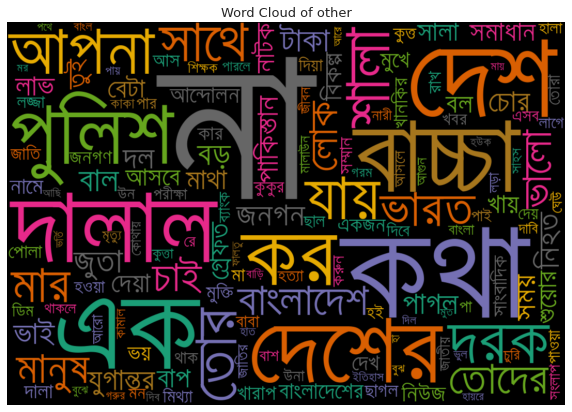

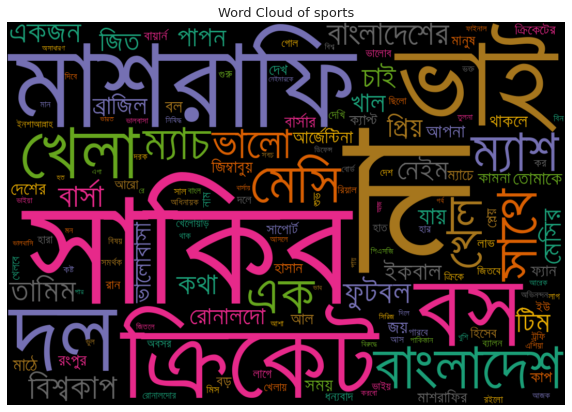

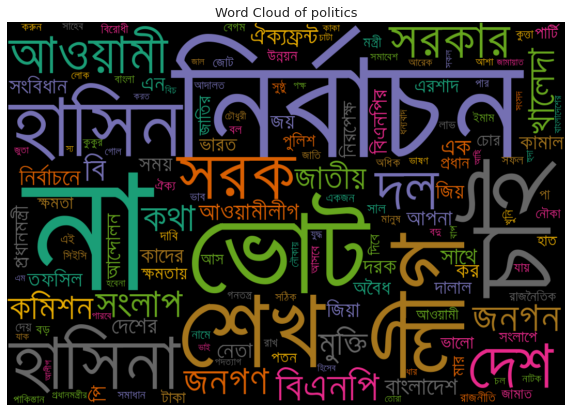

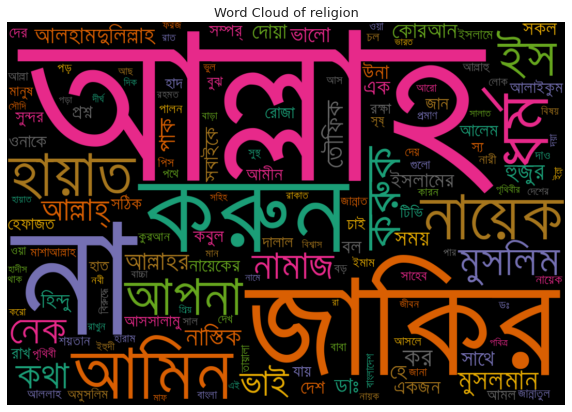

In [35]:
from collections import Counter
aspect_cat=["other","sports","politics","religion"]
for i in aspect_cat:
    temp_df=df.loc[df['aspect'] == str(i)]
    #display(temp)
    temp_df['temp'] = temp_df['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp_df['temp'] for item in sublist])
    temp = pd.DataFrame(top.most_common(5000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,str(i))

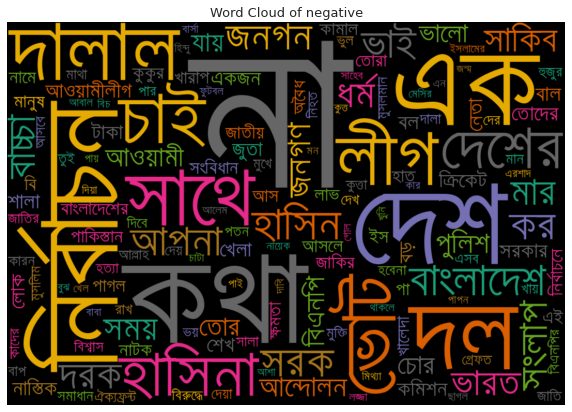

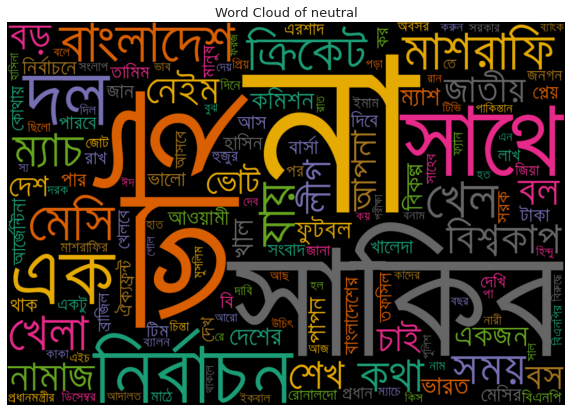

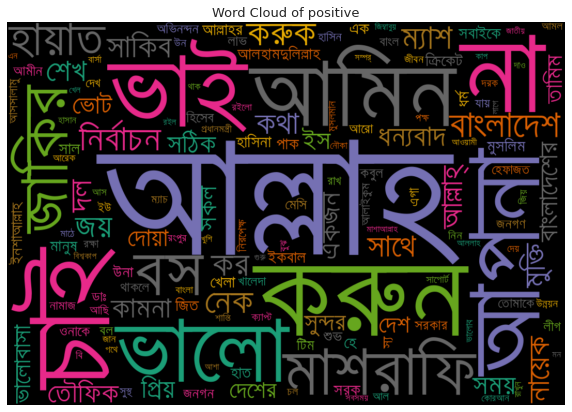

In [36]:
from collections import Counter
polarity_cat=["negative","neutral","positive"]
for i in polarity_cat:
    temp_df=df.loc[df['polarity'] == str(i)]
    #display(temp)
    temp_df['temp'] = temp_df['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp_df['temp'] for item in sublist])
    temp = pd.DataFrame(top.most_common(5000))
    temp.columns = ['Common_words','count']
    generate_wordcloud(temp,str(i))

In [37]:
df['temp_list'] = df['cleanText'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,না,906
1,আল্লাহ,305
2,কথা,216
3,নির্বাচন,208
4,চাই,195
5,ভাই,194
6,এক,189
7,দল,183
8,সাথে,171
9,বাংলাদেশ,168


In [38]:
# Top words in aspect columns (category wise)
from collections import Counter
aspect_cat=["other","sports","politics","religion"]
category_list_aspect=aspect_cat
for i in category_list_aspect:
    temp=df.loc[df['aspect'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In '+ str(i)+" Category")
    display(temp)
    print()
    print()

,0,1
0,না,257
1,কথা,70
2,এক,52
3,দেশ,50
4,বাচ্চা,42
5,দালাল,40
6,দেশের,39
7,পুলিশ,38
8,কর,36
9,আপনা,34


,0,1
0,না,213
1,সাকিব,141
2,মাশরাফি,119
3,ভাই,116
4,ক্রিকেট,97
5,বস,89
6,দল,87
7,খেলা,85
8,বাংলাদেশ,83
9,সাথে,74


,0,1
0,না,291
1,নির্বাচন,203
2,ভোট,123
3,চাই,115
4,লীগ,104
5,শেখ,100
6,হাসিন,99
7,হাসিনা,98
8,সরক,97
9,দেশ,82


,0,1
0,আল্লাহ,292
1,না,145
2,জাকির,106
3,করুন,103
4,আমিন,82
5,ধর্ম,79
6,নায়েক,65
7,হায়াত,64
8,আপনা,63
9,ইস,63


In [39]:
# Top words in aspect columns (category wise)
polarity_cat=["negative","neutral","positive"]
category_list_pol=polarity_cat
for i in category_list_pol:
    temp=df.loc[df['polarity'] == str(i)]
    #display(temp)
    temp['temp_list'] = temp['cleanText'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in temp['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.style.background_gradient(cmap='Blues')
    temp = temp.style.set_caption('Top 20 Words In '+ str(i)+" Category")
    display(temp)
    print()
    print()

,0,1
0,না,710
1,কথা,147
2,দেশ,120
3,এক,117
4,নির্বাচন,108
5,দল,93
6,দালাল,84
7,সাথে,80
8,ভোট,74
9,লীগ,73


,0,1
0,না,97
1,ভাই,49
2,সাকিব,46
3,সাথে,46
4,নির্বাচন,45
5,এক,44
6,দল,44
7,বাংলাদেশ,36
8,মেসি,33
9,মাশরাফি,32


,0,1
0,আল্লাহ,277
1,চাই,106
2,করুন,106
3,না,99
4,ভাই,84
5,আপনা,82
6,আমিন,80
7,ভালো,74
8,মাশরাফি,70
9,জাকির,69


In [40]:
df=df[["cleanText","aspect","polarity"]]
print(df.shape)

(6064, 3)


In [41]:
df.head()

,cleanText,aspect,polarity
3,আওয়ামীলীগ নোং রাজনীতির তীব্র নিন্দা জানা,politics,negative
4,পরিসংখ্যান ম্যাশ হইতো এশিয়া কাপ,sports,neutral
5,রুহুল আমিন হাওল আসনে কয়ভোট পাবে নিজে জানেনা,politics,neutral
7,কিছুদিন মাঠে না ভালোবাসা চিরকাল,sports,positive
8,সংলাপ সফল আন্দোলন চলবে,politics,negative


In [42]:
#Initialize the model

PRE_TRAINED_MODEL_NAME = "sagorsarker/bangla-bert-base" #Bangla bert
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

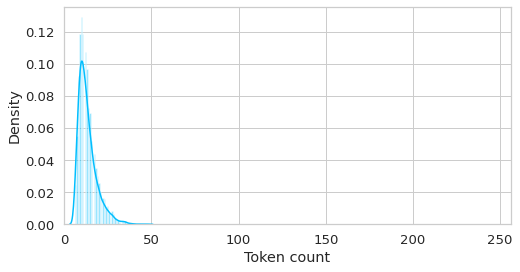

In [43]:
#Choosing Sequence Length
#BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review.
token_lens = []

for txt in df.cleanText:
    tokens = tokenizer.encode(txt,max_length=512) #each row contain fixed length of 512
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')  

In [44]:
# Import label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [45]:
df['aspect']= le.fit_transform(df['aspect'])
df['polarity']= le.fit_transform(df['polarity'])

In [46]:
df.aspect.value_counts()

1    1923
0    1521
2    1313
3    1307
Name: aspect, dtype: int64

# BERT MODEL

In [60]:
#split the data 
df_train, df_test = train_test_split(df,test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print("train shape:",df_train.shape)
print("test shape:",df_test.shape)
print("val shape:",df_val.shape)

train shape: (4851, 3)
test shape: (607, 3)
val shape: (606, 3)


# News Headline Classifications

In [61]:
#---------------------------------Dataset building--------------------------------

class_name=["others","politices","religion","sports"]
MAX_LEN = 40

class NewsHeadlineDataset(Dataset):   
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.text)
  
    def __getitem__(self, index):
        text = str(self.text[index])
        target = self.targets[index]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
                }


In [62]:
#--------------------------Create Data Loader-------------------------------

def create_data_loader(df, tokenizer, max_len, batch_size):
    #create a instance of the GPReview class.
    ds = NewsHeadlineDataset(
        text=df.cleanText.to_numpy(),
        targets=df.aspect.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    
    return DataLoader(
        ds,
        batch_size=batch_size)
    
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [63]:
#--------------------------------Building the model--------------------------------

#initialize the model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

class HeadlineClassifier(nn.Module):

    def __init__(self, n_classes):
        super(HeadlineClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

model = HeadlineClassifier(4)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.pr

In [75]:
#-----------------------------------Training----------------------------------
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

# Traning function
def train_epoch(model, 
                data_loader, 
                loss_fn, 
                optimizer,  
                scheduler, 
                n_examples):
    
    model = model.train() # model becoming in the training mode.

    losses = []
    correct_predictions = 0
  
    for batch in data_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets = batch["targets"]

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        #avoiding the exploiding gradiant
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)



In [64]:
# ------------------------------Evaluation function ----------------------------------------

def eval_model(model, data_loader, loss_fn, n_examples):
    
    model = model.eval() # model becoming in the evaluation mode.(no dropout,batch norm apply)

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            targets = batch["targets"]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)
    

In [ ]:
#--------------------------- starting the training process -------------------------------

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer,  
        scheduler, 
        len(df_train))

    print(f'Train loss : {train_loss}  ##  Training accuracy : {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        len(df_val))

    print(f'Val loss : {val_loss}    ##   Val accuracy : {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/my_thesis/best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/5
----------
Train loss : 0.6687014318374266  ##  Training accuracy : 0.7448341232227488
Val loss : 0.5368347423417228    ##   Val accuracy : 0.8121827411167513

Epoch 2/5
----------
Train loss : 0.30291755380759755  ##  Training accuracy : 0.8961137440758293
Val loss : 0.533408237355096    ##   Val accuracy : 0.8223350253807107

Epoch 3/5
----------
Train loss : 0.18028560426669665  ##  Training accuracy : 0.9393364928909953
Val loss : 0.5453255261693682    ##   Val accuracy : 0.8375634517766497

Epoch 4/5
----------
Train loss : 0.10747264239218939  ##  Training accuracy : 0.966824644549763
Val loss : 0.6116798434938703    ##   Val accuracy : 0.8248730964467005

Epoch 5/5
----------
Train loss : 0.0656955502029643  ##  Training accuracy : 0.9818009478672985
Val loss : 0.6396529078483582    ##   Val accuracy : 0.8223350253807107



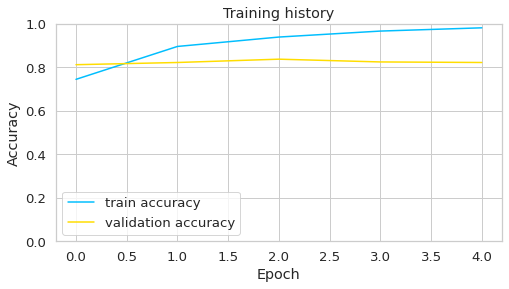

In [ ]:
# ----------------------Visualize the training and validation accuracy ----------------------------------

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]); 

In [65]:
#load the save models
model = HeadlineClassifier(4)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/my_thesis/best_model_state.bin'))

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [76]:
#------------------------------------Evaluation------------------------------
test_acc, _ = eval_model(
  model, 
  test_data_loader,
  loss_fn,
  len(df_test)
)

print("Test accuracy:" ,test_acc.item())

Test accuracy: 0.8682042833607908


In [67]:
#---------------------generate the predictions------------------------------------

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = [] #targets

  with torch.no_grad():
      for d in data_loader:
          texts = d["review_text"]
          input_ids = d["input_ids"]
          attention_mask = d["attention_mask"]
          targets = d["targets"]
          
          #outputs = logits(each class prediction score)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          review_texts.extend(texts)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)
  
  #convert a sequence of tensors(lists) (two or more tensors) into a new dimension(single tensor). 
  # joins the tensors with the same dimensions and shape.
  predictions = torch.stack(predictions)
  prediction_probs = torch.stack(prediction_probs)
  real_values = torch.stack(real_values)
  
  return review_texts, predictions, prediction_probs, real_values

In [68]:
# call the function
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader)     
      
# check the classification report 
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

      others       0.79      0.81      0.80       154
   politices       0.88      0.87      0.88       205
    religion       0.86      0.91      0.88       120
      sports       0.96      0.90      0.93       128

    accuracy                           0.87       607
   macro avg       0.87      0.87      0.87       607
weighted avg       0.87      0.87      0.87       607



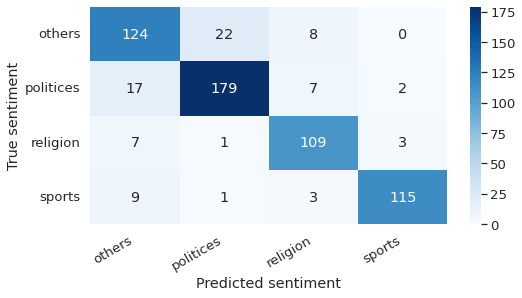

In [69]:
# check the confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

# Generate predictions


In [ ]:
def predictins(text):
  text=preprocessing(str(text))
  text=stopwordRemoval(str(text))
  text=stem_text(str(text))
    
  encoded = tokenizer.encode_plus(
      text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt' )

  input_ids = encoded['input_ids']
  attention_mask = encoded['attention_mask']
  output1 = model(input_ids, attention_mask)
  _, prediction1 = torch.max(output1, dim=1)
  print()
  print()
  print(f'text: {text}')
  print(f'Headline class  : {class_name[prediction1]}')



applied second rules..
applied first rules..
applied fourth rules..
applied first rules..


text: বিসিবি থেকেনান্নু পাপন
Headline class  : sports
Sentiment  : positive


In [ ]:
# set your headline for predicting the outputs.
text = "বিসিবি থেকে,নান্নু আর পাপনকে আগে বাদ দিতে হবে।।	"

# call for the generate function.
predictins(text)

applied second rules..
applied first rules..
applied first rules..


Original text: এগিয়ে যাও বাংগালীরা
Predicted Headline class : others
Predicted Sentiment : positive
